In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from ClickReaction import BocRemoval
from ClickReaction import CuAAC
from rdkit.Chem import  Descriptors
from rdkit.Chem.Draw import IPythonConsole
import io
import itertools
from PIL import Image
from ClickReaction import BocRemoval
from tqdm import tqdm
import re
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
import csv

In [2]:
def replace_specific_pattern(text, pattern, replacement):
    return re.sub(pattern, replacement, text)
rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')

In [3]:
def amine_selec(smiles = 'NC(=O)CCCC'):
    molecule = Chem.MolFromSmiles(smiles)
    primary_amine_pattern = Chem.MolFromSmarts('[N;X3;H2][#6;!$(C=[O,N,S])]')
    if molecule.HasSubstructMatch(primary_amine_pattern):
        return True
    else:
        return False
# 脂肪胺的讨论

In [4]:
def Ar_amine_selec(smiles = 'NC(=O)CCCC'):
    molecule = Chem.MolFromSmiles(smiles)
    primary_amine_pattern = Chem.MolFromSmarts('[N;X3;H2][c;X3]')
    if molecule.HasSubstructMatch(primary_amine_pattern):
        return True
    else:
        return False
# 将芳香胺单独讨论

In [5]:
def count_amide_groups(entry_smiles = 'c(CNC)1c(N)c(CCN)c(C(=O)NC)c(C(=N)N)c1'):
    mol = Chem.MolFromSmiles(entry_smiles)
    if mol is None:
        raise ValueError('Invalid molecule')
    amide_pattern = Chem.MolFromSmarts('[N;X3;H2][C]=[O,N,S]')
    amide_groups = mol.GetSubstructMatches((amide_pattern))
    return len(amide_groups)
# 判断分子中C(O)NH2的个数

In [6]:
amine_selec('c(CNC)1c(N)c(CCN)c(C(=O)NC)c(C(=N)N)c1')

True

In [7]:
def smiles_to_image_grid(smiles_list, img_size=(200, 200), mols_per_row=4, kekulize=True):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    if kekulize:
        for mol in mols:
            Chem.Kekulize(mol)
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=img_size)
    return img

In [8]:
def identify_aromatic_amine(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        raise ValueError("Invalid SMILES string")

    phenylamine_pattern = Chem.MolFromSmarts("c1ccccc1[NH2]")
    pyridinamine_pattern = Chem.MolFromSmarts("[c,n]1[c,n][c,n][c,n][c,n][c,n]1[NH2]")

    is_phenylamine = mol.HasSubstructMatch(phenylamine_pattern)
    is_pyridinamine = mol.HasSubstructMatch(pyridinamine_pattern)

    if is_phenylamine:
        return True
    elif not is_phenylamine and is_pyridinamine :
        return False
    else:
        return True
# 六元含氮杂环排除

In [9]:
def save_list_to_csv(filename, data_list):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        for item in data_list:
            csv_writer.writerow([item])

In [10]:
with open ('./BiDe_NH2.csv','r') as f:
    lines = f.readlines()
    amine_smiles = [l.split(',') for l in lines]
amine_smiles = amine_smiles[1:]


In [11]:
tot_comp_smiles = []
a = []
for i in range(len(amine_smiles)):
    if '.' not in amine_smiles[i][-10]:
        if amine_smiles[i][-10] not in a:
            tot_comp_smiles.append([amine_smiles[i][-10],amine_smiles[i][-3]])
            a.append(amine_smiles[i][-10])
    else:
        for j in amine_smiles[i][-10].split('.'):
            if j not in a:
                tot_comp_smiles.append([j,amine_smiles[i][-3]])
                a.append(j)

In [170]:
amine_smiles_list_1 = []
Ar_amine_smiles_list_1 = []
amine_smiles_list_2 = []
amide_smiles_list = []
for i in range(len(tot_comp_smiles)):
    a = Fragments.fr_NH2(Chem.MolFromSmiles(tot_comp_smiles[i][0]))
    NH2_number = a-count_amide_groups(tot_comp_smiles[i][0])
    molecular = Chem.MolFromSmiles(tot_comp_smiles[i][0])
    if float(tot_comp_smiles[i][1])>0.0 and NH2_number>0.0:
        pass
    elif a ==0:
        pass
    elif NH2_number == 1.0:
        if Ar_amine_selec(tot_comp_smiles[i][0]) == True:
            Ar_amine_smiles_list_1.append(tot_comp_smiles[i][0])
        elif amine_selec(tot_comp_smiles[i][0]) == True:
            amine_smiles_list_1.append(tot_comp_smiles[i][0])
        else:
            amide_smiles_list.append(tot_comp_smiles[i][0])
    elif count_amide_groups(tot_comp_smiles[i][0]) >0 and NH2_number ==0 :
        amide_smiles_list.append(tot_comp_smiles[i][0])
    else:
        amine_smiles_list_2.append(tot_comp_smiles[i][0])

In [171]:
py_amine_smiles_list_1 = []
for i in Ar_amine_smiles_list_1:
    if identify_aromatic_amine(i) ==True:
        amine_smiles_list_1.append(i)
    else:
        py_amine_smiles_list_1.append(i)

In [173]:
save_list_to_csv('/home/pku/BiDe/BiDe_NH2_sele.csv', amine_smiles_list_1)


In [177]:
len(amine_smiles_list_1)

10072

/home/anaconda3/envs/shabi/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


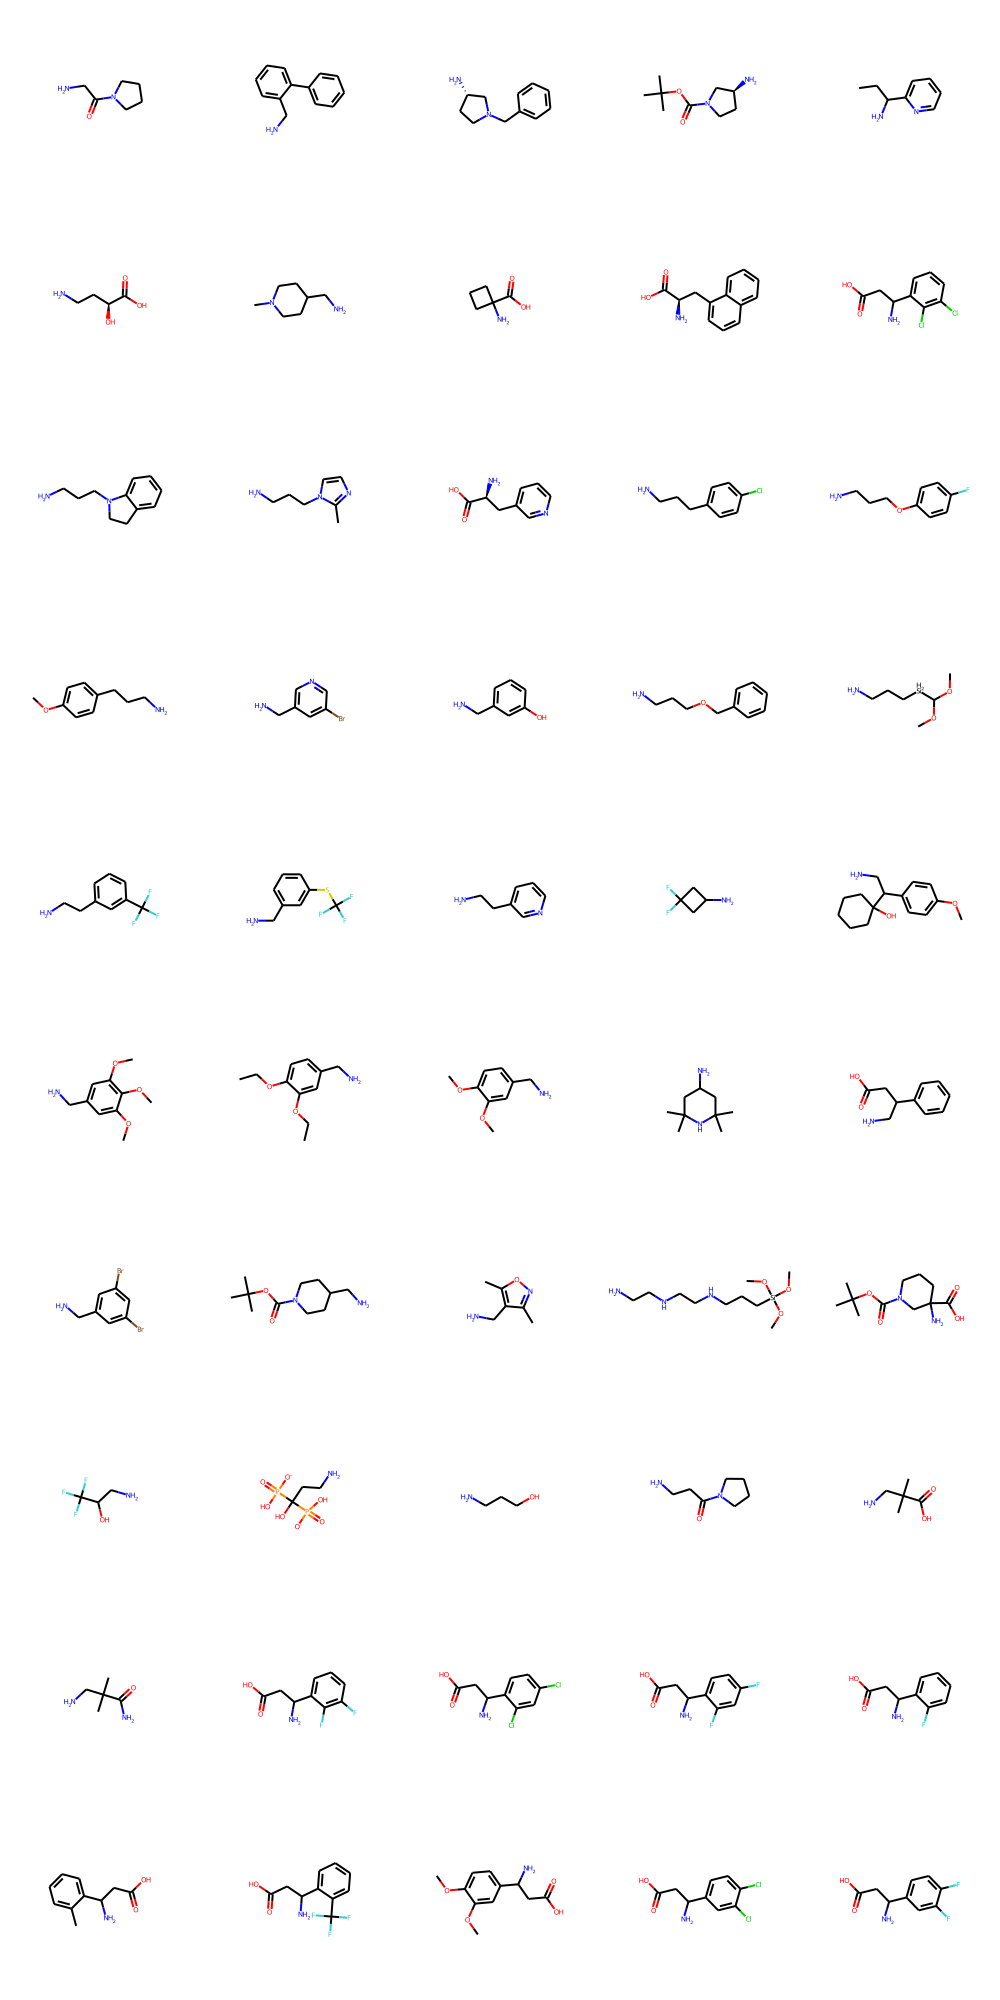

In [174]:
smiles_to_image_grid(amine_smiles_list_1_new[0:100], img_size=(200, 200), mols_per_row=5, kekulize=True)

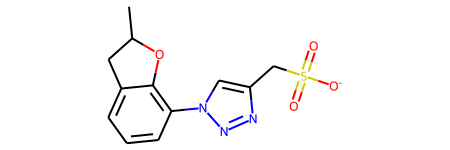

In [11]:
Chem.MolFromSmiles('CC1Cc2cccc(N3C=C(CS(=O)(=O)[O-])N=N3)c2O1')
